In [2]:
from __future__ import annotations

import json
import math
from typing import Any, Dict, List, Optional, Set, Tuple

import cv2
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from skimage.morphology import skeletonize




In [ ]:
# ============================================================
# A) Utilidades de visualización base
# ============================================================

def show_gray(
    img: np.ndarray,
    *,
    title: str = "Grayscale",
    figsize: Tuple[int, int] = (7, 7),
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
) -> None:
    """
    Muestra una imagen en escala de grises.

    Parámetros
    ----------
    img : np.ndarray (H,W)
    title : str
    figsize : (w,h)
    vmin, vmax : float | None
        Rango de visualización (si None, auto).
    """
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap="gray", vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.axis("off")
    plt.show()


def show_bool_mask(
    mask: np.ndarray,
    *,
    title: str = "Mask",
    figsize: Tuple[int, int] = (7, 7),
) -> None:
    """
    Muestra una máscara booleana (True/False).
    """
    show_gray(mask.astype(np.uint8) * 255, title=title, figsize=figsize, vmin=0, vmax=255)


def show_two_masks(
    mask_a: np.ndarray,
    mask_b: np.ndarray,
    *,
    title_a: str = "Mask A",
    title_b: str = "Mask B",
    figsize: Tuple[int, int] = (12, 6),
) -> None:
    """
    Muestra dos máscaras lado a lado.
    """
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.imshow(mask_a.astype(np.uint8) * 255, cmap="gray", vmin=0, vmax=255)
    plt.title(title_a)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask_b.astype(np.uint8) * 255, cmap="gray", vmin=0, vmax=255)
    plt.title(title_b)
    plt.axis("off")
    plt.show()


def show_distance_transform(
    dist: np.ndarray,
    *,
    title: str = "Distance Transform (cells)",
    figsize: Tuple[int, int] = (7, 7),
    percentile_clip: Tuple[float, float] = (1.0, 99.0),
) -> None:
    """
    Visualiza el distance transform con recorte robusto por percentiles.

    Parámetros
    ----------
    dist : np.ndarray (H,W) float
    percentile_clip : (p_low, p_high)
        Recorta el rango para evitar que 2-3 valores extremos “aplasten” el contraste.
    """
    d = dist.copy()
    lo, hi = np.percentile(d[np.isfinite(d)], list(percentile_clip))
    plt.figure(figsize=figsize)
    plt.imshow(d, vmin=lo, vmax=hi)
    plt.title(title)
    plt.axis("off")
    plt.colorbar(shrink=0.75)
    plt.show()


def show_overlay(
    base_gray: np.ndarray,
    overlay_mask: np.ndarray,
    *,
    title: str = "Overlay",
    figsize: Tuple[int, int] = (7, 7),
    alpha: float = 0.6,
) -> None:
    """
    Superpone una máscara (overlay_mask) sobre una imagen base en gris.
    """
    plt.figure(figsize=figsize)
    plt.imshow(base_gray, cmap="gray")
    plt.imshow(overlay_mask.astype(float), alpha=alpha)  # colormap default
    plt.title(title)
    plt.axis("off")
    plt.show()


# ============================================================
# B) Visualización específica del pipeline
# ============================================================

def preview_binary_masks(
    masks: Dict[str, np.ndarray],
    *,
    figsize: Tuple[int, int] = (18, 6),
) -> None:
    """
    Muestra free / obstacle / unknown (si existe) en una sola figura.
    """
    free = masks.get("free")
    obst = masks.get("obstacle")
    unk = masks.get("unknown")

    n = 3 if unk is not None else 2
    plt.figure(figsize=figsize)

    plt.subplot(1, n, 1)
    plt.imshow(free.astype(np.uint8) * 255, cmap="gray", vmin=0, vmax=255)
    plt.title("free")
    plt.axis("off")

    plt.subplot(1, n, 2)
    plt.imshow(obst.astype(np.uint8) * 255, cmap="gray", vmin=0, vmax=255)
    plt.title("obstacle")
    plt.axis("off")

    if unk is not None:
        plt.subplot(1, n, 3)
        plt.imshow(unk.astype(np.uint8) * 255, cmap="gray", vmin=0, vmax=255)
        plt.title("unknown")
        plt.axis("off")

    plt.show()


def preview_skeleton(
    base: np.ndarray,
    skel: np.ndarray,
    *,
    title: str = "Skeleton overlay",
    figsize: Tuple[int, int] = (7, 7),
    alpha: float = 0.7,
) -> None:
    """
    Muestra el skeleton superpuesto sobre una base (PGM o una máscara libre).
    """
    base_gray = base
    if base_gray.dtype == bool:
        base_gray = base_gray.astype(np.uint8) * 255
    show_overlay(base_gray, skel, title=title, figsize=figsize, alpha=alpha)


def preview_graph_nodes_edges_on_grid(
    base: np.ndarray,
    G: nx.Graph,
    *,
    title: str = "Graph on grid",
    figsize: Tuple[int, int] = (8, 8),
    draw_labels: bool = False,
) -> None:
    """
    Dibuja el grafo (nodos y aristas) superpuesto sobre un grid (imagen base).

    - Nodos: puntos
    - Aristas: si hay path_cells (polilínea) dibuja esa polilínea; si no, dibuja segmento entre nodos.

    Parámetros
    ----------
    base : np.ndarray (H,W)
        Imagen base (PGM uint8, o máscara en bool).
    draw_labels : bool
        Si True, dibuja id del nodo (puede saturar si hay muchos).
    """
    base_gray = base
    if base_gray.dtype == bool:
        base_gray = base_gray.astype(np.uint8) * 255

    plt.figure(figsize=figsize)
    plt.imshow(base_gray, cmap="gray")
    plt.title(title)
    plt.axis("off")

    # Aristas
    for u, v, data in G.edges(data=True):
        # preferencia: polilínea en grid
        path = data.get("path_cells")
        if path and len(path) >= 2:
            rr = [rc[0] for rc in path]
            cc = [rc[1] for rc in path]
            plt.plot(cc, rr)  # x=col, y=row
        else:
            r0, c0 = G.nodes[u]["cell"]
            r1, c1 = G.nodes[v]["cell"]
            plt.plot([c0, c1], [r0, r1])

    # Nodos
    for nid, nd in G.nodes(data=True):
        r, c = nd["cell"]
        plt.scatter([c], [r], s=20)
        if draw_labels:
            plt.text(c + 1, r + 1, nid, fontsize=8)

    plt.show()


def preview_graph_straight_edges_only(
    base: np.ndarray,
    G: nx.Graph,
    *,
    title: str = "Straight (LOS) edges",
    figsize: Tuple[int, int] = (8, 8),
) -> None:
    """
    Visualiza solo las aristas rectas (is_straight=True) sobre el grid.
    """
    base_gray = base
    if base_gray.dtype == bool:
        base_gray = base_gray.astype(np.uint8) * 255

    plt.figure(figsize=figsize)
    plt.imshow(base_gray, cmap="gray", origin="lower")#TODO: ESTO QUITAR Y PONER SEGUN CONVENGA
    plt.title(title)
    plt.axis("off")

    # aristas LOS
    for u, v, data in G.edges(data=True):
        if data.get("enabled") is False:
            continue
        if not data.get("is_straight", False):
            continue
        r0, c0 = G.nodes[u]["cell"]
        r1, c1 = G.nodes[v]["cell"]
        plt.plot([c0, c1], [r0, r1])

    # nodos
    for _, nd in G.nodes(data=True):
        r, c = nd["cell"]
        plt.scatter([c], [r], s=20)

    plt.show()


def preview_node_labels(
    base: np.ndarray,
    G: nx.Graph,
    *,
    label_key: str = "space",
    title: str = "Node labels",
    figsize: Tuple[int, int] = (10, 10),
) -> None:
    """
    Visualiza nodos y escribe su etiqueta (label_key) al lado.

    Útil para validar tu diccionario de rectángulos.
    """
    base_gray = base
    if base_gray.dtype == bool:
        base_gray = base_gray.astype(np.uint8) * 255

    plt.figure(figsize=figsize)
    plt.imshow(base_gray, cmap="gray")
    plt.title(title)
    plt.axis("off")

    for nid, nd in G.nodes(data=True):
        r, c = nd["cell"]
        lbl = nd.get("labels", {}).get(label_key)
        plt.scatter([c], [r], s=20)
        if lbl is not None:
            plt.text(c + 2, r + 2, str(lbl), fontsize=8)

    plt.show()


# ============================================================
# C) Inspección rápida (texto) de estructuras
# ============================================================

def summarize_masks(masks: Dict[str, np.ndarray]) -> Dict[str, Any]:
    """
    Devuelve estadísticas rápidas (counts) de las máscaras.
    """
    out = {}
    for k, m in masks.items():
        if m is None:
            continue
        out[k] = {
            "count_true": int(m.sum()),
            "count_false": int(m.size - m.sum()),
            "ratio_true": float(m.mean()),
            "shape": tuple(m.shape),
            "dtype": str(m.dtype),
        }
    return out


def summarize_graph(G: nx.Graph, *, top_k: int = 10) -> Dict[str, Any]:
    """
    Resumen rápido del grafo para depuración.
    """
    n = G.number_of_nodes()
    e = G.number_of_edges()
    degs = [d for _, d in G.degree()]
    out = {
        "nodes": n,
        "edges": e,
        "avg_degree": float(np.mean(degs)) if degs else 0.0,
        "max_degree": int(np.max(degs)) if degs else 0,
        "min_degree": int(np.min(degs)) if degs else 0,
        "graph_attrs": dict(G.graph),
    }

    # top nodos por grado
    top = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:top_k]
    out["top_nodes_by_degree"] = [{"id": nid, "deg": int(d)} for nid, d in top]
    return out





In [4]:
def load_pgm_gray(path: str, invert: bool = False) -> np.ndarray:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(path)
    return (255 - img) if invert else img


def pgm_to_masks(
    img: np.ndarray,
    *,
    free_threshold: int,
    occ_threshold: int,
    mid_is_unknown: bool,
    unknown_is_obstacle: bool,
) -> Dict[str, np.ndarray]:
    free = img >= free_threshold
    obstacle = img <= occ_threshold
    unknown = (~(free | obstacle)) if mid_is_unknown else np.zeros_like(free, bool)

    if unknown_is_obstacle:
        obstacle = obstacle | unknown
        free = ~obstacle

    return {"free": free, "obstacle": obstacle, "unknown": unknown}


def clean_mask(mask: np.ndarray, open_iters = 0, close_iters = 1, kernel = 3) -> np.ndarray:
    k = np.ones((kernel, kernel), np.uint8)
    x = (mask.astype(np.uint8) * 255)
    x = cv2.morphologyEx(x, cv2.MORPH_OPEN, k, iterations=open_iters)
    x = cv2.morphologyEx(x, cv2.MORPH_CLOSE, k, iterations=close_iters)
    return x > 0


def keep_largest_component(mask: np.ndarray) -> np.ndarray:
    x = mask.astype(np.uint8)
    n, labels = cv2.connectedComponents(x)
    if n <= 1:
        return mask
    counts = np.bincount(labels.reshape(-1))
    counts[0] = 0
    keep = counts.argmax()
    return labels == keep




def distance_transform(free_mask: np.ndarray):
    src = free_mask.astype(np.uint8) * 255
    return cv2.distanceTransform(src, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)

def skeleton_free(free_mask: np.ndarray) -> np.ndarray:
    return skeletonize(free_mask).astype(bool, copy=False)

def filter_skeleton_by_clearance(skel: np.ndarray, dist_cells: np.ndarray, min_clearance_cells: float) -> np.ndarray:
    return skel & (dist_cells >= min_clearance_cells)




def skeleton_degree(skel: np.ndarray) -> np.ndarray:
    k = np.array([[1, 1, 1],
                  [1, 0, 1],
                  [1, 1, 1]], dtype=np.uint8)
    return cv2.filter2D(skel.astype(np.uint8), -1, k, borderType=cv2.BORDER_CONSTANT)


def cell_to_xy(cell: Tuple[int, int], resolution_m: float, origin_xy_m: Tuple[float, float]) -> Tuple[float, float]:
    r, c = cell
    x0, y0 = origin_xy_m
    return (x0 + c * resolution_m, y0 + r * resolution_m)


def neighbors8(cell: Tuple[int, int], skeleton: np.ndarray) -> List[Tuple[int, int]]:
    h, w = skeleton.shape
    r, c = cell
    out: List[Tuple[int, int]] = []
    for dr in (-1, 0, 1):
        for dc in (-1, 0, 1):
            if dr == 0 and dc == 0:
                continue
            rr, cc = r + dr, c + dc
            if 0 <= rr < h and 0 <= cc < w and skeleton[rr, cc]:
                out.append((rr, cc))
    return out


def skeleton_node_cells(
    skeleton: np.ndarray,
    deg: np.ndarray,
    junction_degree: int,
    include_endpoints: bool,
) -> List[Tuple[int, int]]:
    ys, xs = np.where(skeleton)
    out: List[Tuple[int, int]] = []
    for r, c in zip(ys.tolist(), xs.tolist()):
        d = int(deg[r, c])
        if (include_endpoints and d == 1) or (d >= junction_degree):
            out.append((r, c))
    return out


def node_id_map(node_cells: List[Tuple[int, int]], prefix: str = "n") -> Dict[Tuple[int, int], str]:
    return {cell: f"{prefix}{i}" for i, cell in enumerate(node_cells)}


def init_graph(frame_id: str, resolution_m: float, origin_xy_m: Tuple[float, float]) -> nx.Graph:
    return nx.Graph(frame_id=frame_id, resolution_m=resolution_m, origin_xy_m=origin_xy_m)


def add_nodes_from_cells(
    g: nx.Graph,
    node_id: Dict[Tuple[int, int], str],
    deg: np.ndarray,
    resolution_m: float,
    origin_xy_m: Tuple[float, float],
    junction_degree: int,
) -> None:
    for cell, nid in node_id.items():
        d = int(deg[cell[0], cell[1]])
        g.add_node(
            nid,
            cell=cell,
            xy_m=cell_to_xy(cell, resolution_m, origin_xy_m),
            type=("junction" if d >= junction_degree else "endpoint"),
            labels={},
        )


def trace_edge_path(
    start_node: Tuple[int, int],
    first_step: Tuple[int, int],
    skeleton: np.ndarray,
    node_set: Set[Tuple[int, int]],
) -> List[Tuple[int, int]]:
    path = [start_node]
    prev, cur = start_node, first_step
    while True:
        path.append(cur)
        if cur in node_set:
            return path
        nxt = None
        for cand in neighbors8(cur, skeleton):
            if cand != prev:
                nxt = cand
                break
        if nxt is None:
            return path
        prev, cur = cur, nxt


def add_edges_from_skeleton(
    g: nx.Graph,
    node_id: Dict[Tuple[int, int], str],
    skeleton: np.ndarray,
) -> None:
    node_set = set(node_id.keys())
    visited: Set[Tuple[Tuple[int, int], Tuple[int, int]]] = set()

    for u_cell, u in node_id.items():
        for v_cell in neighbors8(u_cell, skeleton):
            if (u_cell, v_cell) in visited:
                continue
            visited.add((u_cell, v_cell))

            path = trace_edge_path(u_cell, v_cell, skeleton, node_set)
            end_cell = path[-1]
            if end_cell not in node_set:
                continue

            v = node_id[end_cell]
            if u == v or g.has_edge(u, v):
                continue

            g.add_edge(u, v, path_cells=path, labels={}, metrics={}, enabled=True)


def skeleton_to_graph(
    skel: np.ndarray,
    resolution_m: float,
    origin_xy_m: Tuple[float, float] = (0.0, 0.0),
    frame_id: str = "map",
    junction_degree: int = 3,
    include_endpoints: bool = True,
) -> nx.Graph:
    skeleton = skel.astype(bool)
    deg = skeleton_degree(skeleton)

    nodes = skeleton_node_cells(
        skeleton=skeleton,
        deg=deg,
        junction_degree=junction_degree,
        include_endpoints=include_endpoints,
    )
    nid = node_id_map(nodes)

    g = init_graph(frame_id=frame_id, resolution_m=resolution_m, origin_xy_m=origin_xy_m)
    add_nodes_from_cells(
        g=g,
        node_id=nid,
        deg=deg,
        resolution_m=resolution_m,
        origin_xy_m=origin_xy_m,
        junction_degree=junction_degree,
    )
    add_edges_from_skeleton(g=g, node_id=nid, skeleton=skeleton)
    return g


def bresenham(a: Tuple[int, int], b: Tuple[int, int]):
    r0, c0 = a
    r1, c1 = b
    dr, dc = abs(r1 - r0), abs(c1 - c0)
    sr, sc = (1 if r0 < r1 else -1), (1 if c0 < c1 else -1)
    err = dr - dc
    r, c = r0, c0
    while True:
        yield r, c
        if (r, c) == (r1, c1):
            break
        e2 = 2 * err
        if e2 > -dc:
            err -= dc
            r += sr
        if e2 < dr:
            err += dr
            c += sc


def segment_ok(
    free_mask: np.ndarray,
    a: Tuple[int, int],
    b: Tuple[int, int],
    dist_cells: Optional[np.ndarray] = None,
    min_clearance_cells: float = 0.0,
) -> bool:
    if min_clearance_cells > 0 and dist_cells is None:
        raise ValueError("dist_cells required when min_clearance_cells > 0")
    for r, c in bresenham(a, b):
        if not free_mask[r, c]:
            return False
        if dist_cells is not None and dist_cells[r, c] < min_clearance_cells:
            return False
    return True



def path_to_los_anchors(
    free_mask: np.ndarray,
    path_cells: List[Tuple[int, int]],
    dist_cells: Optional[np.ndarray],
    min_clearance_cells: float,
) -> List[Tuple[int, int]]:
    if len(path_cells) < 2:
        return path_cells

    anchors = [path_cells[0]]
    i, n = 0, len(path_cells)

    while i < n - 1:
        best = i + 1
        j = i + 1
        while j < n and segment_ok(free_mask, path_cells[i], path_cells[j], dist_cells, min_clearance_cells):
            best = j
            j += 1
        anchors.append(path_cells[best])
        i = best

    return anchors


def edges_to_los_chains(
    g: nx.Graph,
    free_mask: np.ndarray,
    dist_cells: Optional[np.ndarray],
    min_clearance_m: float,
) -> nx.Graph:
    res = float(g.graph.get("resolution_m", 1.0))
    origin = tuple(g.graph.get("origin_xy_m", (0.0, 0.0)))
    frame_id = g.graph.get("frame_id", "map")
    min_clearance_cells = (min_clearance_m / res) if min_clearance_m > 0 else 0.0

    def xy(cell: Tuple[int, int]) -> Tuple[float, float]:
        r, c = cell
        x0, y0 = origin
        return (x0 + c * res, y0 + r * res)

    out = nx.Graph(frame_id=frame_id, resolution_m=res, origin_xy_m=origin)
    for nid, nd in g.nodes(data=True):
        out.add_node(nid, **nd)

    turn_idx = 0
    def new_turn_id():
        nonlocal turn_idx
        tid = f"t{turn_idx}"
        turn_idx += 1
        return tid

    for u, v, ed in g.edges(data=True):
        if ed.get("enabled") is False:
            continue
        path = ed.get("path_cells")
        if not path or len(path) < 2:
            continue

        anchors = path_to_los_anchors(free_mask, path, dist_cells, min_clearance_cells)
        chain = [u]
        for cell in anchors[1:-1]:
            tid = new_turn_id()
            out.add_node(tid, cell=cell, xy_m=xy(cell), type="turn", labels={})
            chain.append(tid)
        chain.append(v)

        for a, b in zip(chain[:-1], chain[1:]):
            ax, ay = out.nodes[a]["xy_m"]
            bx, by = out.nodes[b]["xy_m"]
            out.add_edge(
                a, b,
                enabled=True,
                is_straight=True,
                geometry={"segment_xy_m": [(ax, ay), (bx, by)]},
                labels={},
                metrics={"length_m": float(math.hypot(bx - ax, by - ay))}
            )

    return out


# ---------- Node snap/merge (reduce clusters) ----------
def snap_merge_nodes(g: nx.Graph, snap_radius_cells: int = 3) -> nx.Graph:
    out = nx.Graph(**g.graph)

    buckets: Dict[Tuple[int, int], List[str]] = {}
    for nid, nd in g.nodes(data=True):
        r, c = nd["cell"]
        key = (int(r // snap_radius_cells), int(c // snap_radius_cells))
        buckets.setdefault(key, []).append(nid)

    representative: Dict[str, str] = {}
    for key, nodes in buckets.items():
        if len(nodes) == 1:
            nid = nodes[0]
            out.add_node(nid, **g.nodes[nid])
            representative[nid] = nid
            continue

        rs = [g.nodes[n]["cell"][0] for n in nodes]
        cs = [g.nodes[n]["cell"][1] for n in nodes]
        r0 = int(round(float(np.mean(rs))))
        c0 = int(round(float(np.mean(cs))))
        rep = f"m{key[0]}_{key[1]}"

        base = dict(g.nodes[nodes[0]])
        base["cell"] = (r0, c0)
        out.add_node(rep, **base)

        for n in nodes:
            representative[n] = rep

    for u, v, ed in g.edges(data=True):
        uu, vv = representative[u], representative[v]
        if uu == vv:
            continue
        if out.has_edge(uu, vv):
            continue
        out.add_edge(uu, vv, **ed)

    return out


# ---------- Labels ----------
def label_nodes_by_rectangles(
    g: nx.Graph,
    rectangles: List[Dict[str, Any]],
    label_key: str = "space",
    priority: str = "first",
) -> None:
    def contains(cell: Tuple[int, int], rect: Dict[str, Any]) -> bool:
        r, c = cell
        r0, c0 = rect["start_rc"]
        h, w = int(rect["h"]), int(rect["w"])
        return (r0 <= r < r0 + h) and (c0 <= c < c0 + w)

    for nid, nd in g.nodes(data=True):
        matches = [r["label"] for r in rectangles if contains(nd["cell"], r)]
        if not matches:
            continue
        labels = nd.setdefault("labels", {})
        if priority == "first":
            labels.setdefault(label_key, matches[0])
        elif priority == "last":
            labels[label_key] = matches[-1]
        elif priority == "all":
            labels[label_key] = matches
        else:
            raise ValueError("priority must be: first, last, all")


# ---------- JSON ----------
def graph_to_llm_json(g: nx.Graph, include_disabled_edges: bool = False) -> str:
    payload = {
        "frame": g.graph.get("frame_id", "map"),
        "resolution_m": g.graph.get("resolution_m", 1.0),
        "origin_xy_m": list(g.graph.get("origin_xy_m", (0.0, 0.0))),
        "nodes": [],
        "edges": [],
    }

    for nid, nd in g.nodes(data=True):
        node = {"id": nid, **nd}
        r, c = node["cell"]
        node["cell"] = [int(r), int(c)]
        x, y = node["xy_m"]
        node["xy_m"] = [float(x), float(y)]
        payload["nodes"].append(node)

    for u, v, ed in g.edges(data=True):
        if not include_disabled_edges and ed.get("enabled") is False:
            continue
        payload["edges"].append({"from": u, "to": v, **ed})

    return json.dumps(payload, ensure_ascii=False, indent=2)



In [5]:
# ============================================================
# FRONTIERS (detección + clustering + ranking + proyección a grafo)
# ============================================================

def frontier_mask(
    free: np.ndarray,
    unknown: np.ndarray,
    *,
    connectivity8: bool = True,
) -> np.ndarray:
    k = np.ones((3, 3), np.uint8) if connectivity8 else np.array([[0, 1, 0],
                                                                  [1, 1, 1],
                                                                  [0, 1, 0]], np.uint8)
    unk_nb = cv2.dilate(unknown.astype(np.uint8), k, iterations=1) > 0
    return free & unk_nb


def cluster_frontiers(
    frontier: np.ndarray,
    *,
    min_size_cells: int = 20,
    connectivity: int = 8,
) -> List[Dict[str, Any]]:
    x = (frontier.astype(np.uint8) * 255)
    n, labels, stats, centroids = cv2.connectedComponentsWithStats(x, connectivity=connectivity)

    out: List[Dict[str, Any]] = []
    for i in range(1, n):
        area = int(stats[i, cv2.CC_STAT_AREA])
        if area < min_size_cells:
            continue

        cx, cy = centroids[i]  # (x=col, y=row)
        top = int(stats[i, cv2.CC_STAT_TOP])
        left = int(stats[i, cv2.CC_STAT_LEFT])
        height = int(stats[i, cv2.CC_STAT_HEIGHT])
        width = int(stats[i, cv2.CC_STAT_WIDTH])

        out.append({
            "id": f"f{i}",
            "size_cells": area,
            "centroid_rc": (int(round(cy)), int(round(cx))),
            "bbox_rcwh": (top, left, height, width),
        })
    return out




def rank_frontiers_by_size(frontiers):
    return sorted(frontiers, key=lambda f: f["size_cells"], reverse=True)



# ============================================================
# JSON (separado: grafo vs frontiers) + wrapper
# ============================================================

def frontiers_to_llm_json(
    frontiers_scored: List[Dict[str, Any]],
    *,
    frame_id: str = "map",
    resolution_m: float = 1.0,
    origin_xy_m: Tuple[float, float] = (0.0, 0.0),
    top_k: int = 15,
) -> str:
    payload = {
        "frame": frame_id,
        "resolution_m": float(resolution_m),
        "origin_xy_m": [float(origin_xy_m[0]), float(origin_xy_m[1])],
        "frontiers": [],
    }

    for f in frontiers_scored[:top_k]:
        item = dict(f)

        if isinstance(item.get("centroid_rc"), tuple):
            r, c = item["centroid_rc"]
            item["centroid_rc"] = [int(r), int(c)]

        if isinstance(item.get("bbox_rcwh"), tuple):
            t, l, h, w = item["bbox_rcwh"]
            item["bbox_rcwh"] = [int(t), int(l), int(h), int(w)]

        if isinstance(item.get("centroid_xy_m"), tuple):
            x, y = item["centroid_xy_m"]
            item["centroid_xy_m"] = [float(x), float(y)]

        payload["frontiers"].append(item)

    return json.dumps(payload, ensure_ascii=False, indent=2)


def merge_graph_and_frontiers_json(
    graph_json: str,
    frontiers_json: str,
) -> str:
    g = json.loads(graph_json)
    f = json.loads(frontiers_json)
    g["frontiers"] = f.get("frontiers", [])
    return json.dumps(g, ensure_ascii=False, indent=2)


# ============================================================
# ONE-SHOT PIPELINE: grafo + frontiers + wrapper combinado
# (depende de tus funciones existentes)
# ============================================================

def build_los_graph_and_frontiers_json_from_pgm(
    pgm_path: str,
    *,
    robot_xy_m: Tuple[float, float],

    # --- mapa/frames
    resolution_m: float = 0.05,
    origin_xy_m: Tuple[float, float] = (0.0, 0.0),
    frame_id: str = "map",
    invert_pgm: bool = False,

    # --- segmentación PGM
    free_threshold: int = 250,
    occ_threshold: int = 50,
    mid_is_unknown: bool = True,
    unknown_is_obstacle: bool = False,  # recomendado para frontiers

    # --- limpieza / skeleton / grafo
    open_iters: int = 1,
    close_iters: int = 1,
    clean_kernel: int = 3,
    keep_largest: bool = True,
    use_known_only: bool = True,
    skeleton_min_clearance_cells: float = 0.0,
    junction_degree: int = 3,
    include_endpoints: bool = True,
    los_min_clearance_m: float = 0.20,
    snap_radius_cells: int = 3,

    rectangles: Optional[List[Dict[str, Any]]] = None,
    label_key: str = "space",
    label_priority: str = "first",
    include_disabled_edges: bool = False,

    # --- frontiers
    frontier_connectivity8: bool = True,
    frontier_min_size_cells: int = 20,
    top_k_frontiers: int = 15,
    frontier_min_clearance_cells: float = 5.0,
    w_gain: float = 1.0,
    w_cost: float = 1.0,
    w_risk: float = 0.5,
) -> Dict[str, str]:
    # --- 1) cargar + máscaras
    img = load_pgm_gray(pgm_path, invert=invert_pgm)
    masks = pgm_to_masks(
        img,
        free_threshold=free_threshold,
        occ_threshold=occ_threshold,
        mid_is_unknown=mid_is_unknown,
        unknown_is_obstacle=unknown_is_obstacle,
    )

    free_mask = masks["free"]
    if use_known_only:
        free_mask = free_mask & (~masks["unknown"])

    free_mask = clean_mask(free_mask, open_iters=open_iters, close_iters=close_iters, kernel=clean_kernel)
    if keep_largest:
        free_mask = keep_largest_component(free_mask)

    dist = distance_transform(free_mask)
    skel = skeleton_free(free_mask)

    if skeleton_min_clearance_cells > 0:
        skel = filter_skeleton_by_clearance(skel, dist, min_clearance_cells=skeleton_min_clearance_cells)

    g_topo = skeleton_to_graph(
        skel,
        resolution_m=resolution_m,
        origin_xy_m=origin_xy_m,
        frame_id=frame_id,
        junction_degree=junction_degree,
        include_endpoints=include_endpoints,
    )

    g_los = edges_to_los_chains(g_topo, free_mask, dist, min_clearance_m=los_min_clearance_m)
    g_los = snap_merge_nodes(g_los, snap_radius_cells=snap_radius_cells)

    if rectangles:
        label_nodes_by_rectangles(g_los, rectangles, label_key=label_key, priority=label_priority)

    graph_json = graph_to_llm_json(g_los, include_disabled_edges=include_disabled_edges)

    # --- 2) frontiers (sobre el grid original: free + unknown)
    fm = frontier_mask(masks["free"], masks["unknown"], connectivity8=frontier_connectivity8)
    clusters = cluster_frontiers(fm, min_size_cells=frontier_min_size_cells, connectivity=8)
    
    #visualize_frontiers(img_gray=img, frontier_mask=fm, frontiers=clusters)

    frontiers_scored = rank_frontiers_by_size(clusters)

    frontiers_json = frontiers_to_llm_json(
        frontiers_scored,
        frame_id=frame_id,
        resolution_m=resolution_m,
        origin_xy_m=origin_xy_m,
        top_k=top_k_frontiers,
    )

    merged_json = merge_graph_and_frontiers_json(graph_json, frontiers_json)

    return {
        "graph_json": graph_json,
        "frontiers_json": frontiers_json,
        "merged_json": merged_json,
    }


In [6]:
def visualize_frontiers(
    img_gray: np.ndarray,
    frontier_mask: np.ndarray,
    frontiers: List[Dict[str, Any]],
    *,
    show_centroids: bool = True,
    show_ids: bool = True,
    figsize: tuple = (8, 8),
):
    """
    img_gray: np.ndarray (H, W) imagen base en gris
    frontier_mask: np.ndarray bool (H, W)
    frontiers: salida de cluster_frontiers
    """

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Imagen base
    ax.imshow(img_gray, cmap="gray")
    ax.set_title("Frontiers sobre occupancy grid")
    ax.axis("off")

    # Frontier cells (overlay semitransparente)
    fm = np.zeros((*frontier_mask.shape, 4))
    fm[frontier_mask] = [1.0, 0.0, 0.0, 0.6]  # rojo
    ax.imshow(fm)

    # Centroides
    if show_centroids:
        for f in frontiers:
            r, c = f["centroid_rc"]
            ax.plot(c, r, "bo")  # azul
            if show_ids:
                ax.text(
                    c + 2,
                    r + 2,
                    f["id"],
                    color="cyan",
                    fontsize=8,
                    weight="bold",
                )

    plt.tight_layout()
    plt.show()


In [7]:
def visualize_graph_and_frontiers(
    img_gray: np.ndarray,
    G: nx.Graph,
    frontier_mask: np.ndarray,
    frontiers: List[Dict[str, Any]],
    *,
    title: str = "Grafo + Frontiers",
    figsize: Tuple[int, int] = (10, 10),
    frontier_alpha: float = 0.55,
    draw_node_ids: bool = False,
    draw_frontier_ids: bool = True,
    edge_lw: float = 1.0,
    node_s: float = 18.0,
) -> None:
    """
    Visualiza simultáneamente:
      - la imagen base (gris)
      - frontier cells (overlay rojo)
      - centroides de frontiers (azul)
      - grafo (aristas + nodos)

    Nota: el grafo se dibuja en coordenadas de celda (r,c) usando nd["cell"].
    """
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(img_gray, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

    # Frontier overlay
    fm = np.zeros((*frontier_mask.shape, 4), dtype=float)
    fm[frontier_mask] = [1.0, 0.0, 0.0, frontier_alpha]
    ax.imshow(fm)

    # Grafo: aristas
    for u, v, ed in G.edges(data=True):
        if ed.get("enabled") is False:
            continue
        path = ed.get("path_cells")
        if path and len(path) >= 2:
            rr = [rc[0] for rc in path]
            cc = [rc[1] for rc in path]
            ax.plot(cc, rr, linewidth=edge_lw)
        else:
            r0, c0 = G.nodes[u]["cell"]
            r1, c1 = G.nodes[v]["cell"]
            ax.plot([c0, c1], [r0, r1], linewidth=edge_lw)

    # Grafo: nodos
    for nid, nd in G.nodes(data=True):
        r, c = nd["cell"]
        ax.scatter([c], [r], s=node_s)
        if draw_node_ids:
            ax.text(c + 1, r + 1, nid, fontsize=7)

    # Frontiers: centroides
    for f in frontiers:
        r, c = f["centroid_rc"]
        ax.plot(c, r, "bo")
        if draw_frontier_ids:
            ax.text(c + 2, r + 2, f["id"], color="cyan", fontsize=8, weight="bold")

    plt.tight_layout()
    plt.show()


def build_los_graph_and_frontiers_debug_from_pgm(
    pgm_path: str,
    *,
    resolution_m: float = 0.05,
    origin_xy_m: Tuple[float, float] = (0.0, 0.0),
    frame_id: str = "map",
    invert_pgm: bool = False,
    free_threshold: int = 254,
    occ_threshold: int = 50,
    mid_is_unknown: bool = True,
    unknown_is_obstacle: bool = False,
    open_iters: int = 1,
    close_iters: int = 1,
    clean_kernel: int = 3,
    keep_largest: bool = True,
    use_known_only: bool = True,
    skeleton_min_clearance_cells: float = 0.0,
    junction_degree: int = 3,
    include_endpoints: bool = True,
    los_min_clearance_m: float = 0.20,
    snap_radius_cells: int = 3,
    rectangles: Optional[List[Dict[str, Any]]] = None,
    label_key: str = "space",
    label_priority: str = "first",
    include_disabled_edges: bool = False,
    frontier_connectivity8: bool = True,
    frontier_min_size_cells: int = 20,
    top_k_frontiers: int = 15,
    viz: bool = True,
    viz_graph_labels: bool = False,
    viz_node_labels: bool = False,
    viz_frontier_ids: bool = True,
) -> Dict[str, Any]:
    """
    Pipeline de debug (PGM -> máscaras -> grafo LOS + frontiers) con visualizaciones integradas.

    Devuelve:
      - graph_json / frontiers_json / merged_json
      - y además objetos intermedios útiles (img, masks, free_mask, dist, skel, g_topo, g_los, fm, clusters)

    Requisitos: asume que ya existen en tu proyecto:
      load_pgm_gray, pgm_to_masks, clean_mask, keep_largest_component, distance_transform, skeleton_free,
      filter_skeleton_by_clearance, skeleton_to_graph, edges_to_los_chains, snap_merge_nodes,
      label_nodes_by_rectangles, graph_to_llm_json, frontier_mask, cluster_frontiers, rank_frontiers_by_size,
      frontiers_to_llm_json, merge_graph_and_frontiers_json,
      además de: preview_binary_masks, preview_skeleton, show_distance_transform
    """

    # 1) Cargar imagen
    img = load_pgm_gray(pgm_path, invert=invert_pgm)
    if viz:
        show_gray(img, title="0) PGM raw")

    # 2) Máscaras
    masks = pgm_to_masks(
        img,
        free_threshold=free_threshold,
        occ_threshold=occ_threshold,
        mid_is_unknown=mid_is_unknown,
        unknown_is_obstacle=unknown_is_obstacle,
    )
    if viz:
        preview_binary_masks(masks)
        print("masks summary:", summarize_masks(masks))

    # 3) Free mask para grafo (opcional: known-only)
    free_mask = masks["free"]
    if use_known_only:
        free_mask = free_mask & (~masks["unknown"])
    if viz:
        show_bool_mask(free_mask, title="1) free_mask (graph input)")

    # 4) Limpieza + componente mayor
    free_mask = clean_mask(free_mask, open_iters=open_iters, close_iters=close_iters, kernel=clean_kernel)
    if keep_largest:
        free_mask = keep_largest_component(free_mask)
    if viz:
        show_bool_mask(free_mask, title="2) free_mask (clean + largest)")

    # 5) Distance transform + skeleton
    dist = distance_transform(free_mask)
    skel = skeleton_free(free_mask)
    if skeleton_min_clearance_cells > 0:
        skel = filter_skeleton_by_clearance(skel, dist, min_clearance_cells=skeleton_min_clearance_cells)
    if viz:
        show_distance_transform(dist, title="3) distance_transform")
        preview_skeleton(img, skel, title="4) skeleton overlay on PGM")

    # 6) Grafo topológico + LOS + merge
    g_topo = skeleton_to_graph(
        skel,
        resolution_m=resolution_m,
        origin_xy_m=origin_xy_m,
        frame_id=frame_id,
        junction_degree=junction_degree,
        include_endpoints=include_endpoints,
    )
    if viz:
        preview_graph_nodes_edges_on_grid(img, g_topo, title="5) g_topo on PGM", draw_labels=viz_graph_labels)
        print("g_topo summary:", summarize_graph(g_topo))

    g_los = edges_to_los_chains(g_topo, free_mask, dist, min_clearance_m=los_min_clearance_m)
    g_los = snap_merge_nodes(g_los, snap_radius_cells=snap_radius_cells)

    if rectangles:
        label_nodes_by_rectangles(g_los, rectangles, label_key=label_key, priority=label_priority)

    if viz:
        preview_graph_straight_edges_only(img, g_los, title="6) g_los (straight edges) on PGM")
        print("g_los summary:", summarize_graph(g_los))
        if viz_node_labels and rectangles:
            preview_node_labels(img, g_los, label_key=label_key, title="7) node labels")

    graph_json = graph_to_llm_json(g_los, include_disabled_edges=include_disabled_edges)

    # 7) Frontiers sobre masks originales free+unknown
    fm = frontier_mask(masks["free"], masks["unknown"], connectivity8=frontier_connectivity8)
    clusters = cluster_frontiers(fm, min_size_cells=frontier_min_size_cells, connectivity=8)
    frontiers_scored = rank_frontiers_by_size(clusters)

    if viz:
        visualize_frontiers(img_gray=img, frontier_mask=fm, frontiers=clusters, show_ids=viz_frontier_ids)
        visualize_graph_and_frontiers(
            img_gray=img,
            G=g_los,
            frontier_mask=fm,
            frontiers=clusters,
            title="8) g_los + frontiers (same view)",
            draw_node_ids=viz_graph_labels,
            draw_frontier_ids=viz_frontier_ids,
        )

    frontiers_json = frontiers_to_llm_json(
        frontiers_scored,
        frame_id=frame_id,
        resolution_m=resolution_m,
        origin_xy_m=origin_xy_m,
        top_k=top_k_frontiers,
    )

    merged_json = merge_graph_and_frontiers_json(graph_json, frontiers_json)

    return {
        "graph_json": graph_json,
        "frontiers_json": frontiers_json,
        "merged_json": merged_json,
        "debug": {
            "img": img,
            "masks": masks,
            "free_mask": free_mask,
            "dist": dist,
            "skel": skel,
            "g_topo": g_topo,
            "g_los": g_los,
            "frontier_mask": fm,
            "frontier_clusters": clusters,
        },
    }


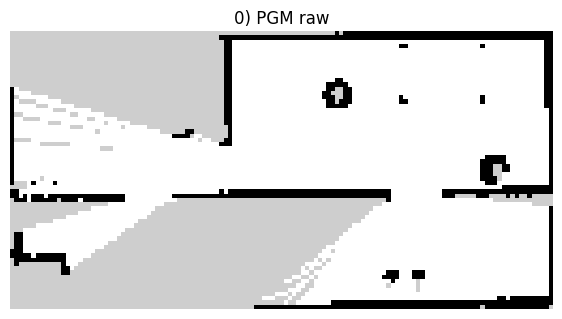

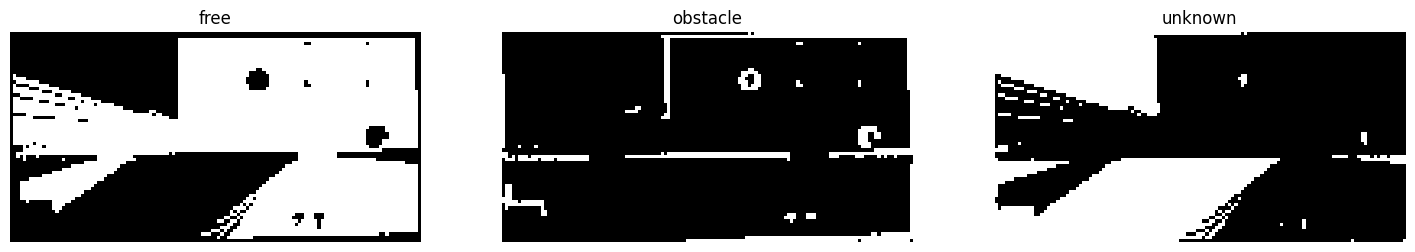

masks summary: {'free': {'count_true': 4791, 'count_false': 3464, 'ratio_true': 0.5803755299818292, 'shape': (65, 127), 'dtype': 'bool'}, 'obstacle': {'count_true': 721, 'count_false': 7534, 'ratio_true': 0.08734100545124167, 'shape': (65, 127), 'dtype': 'bool'}, 'unknown': {'count_true': 2743, 'count_false': 5512, 'ratio_true': 0.33228346456692914, 'shape': (65, 127), 'dtype': 'bool'}}


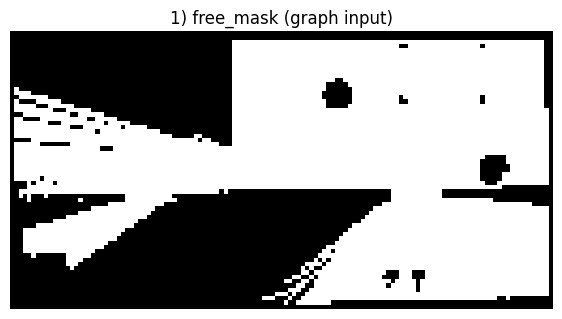

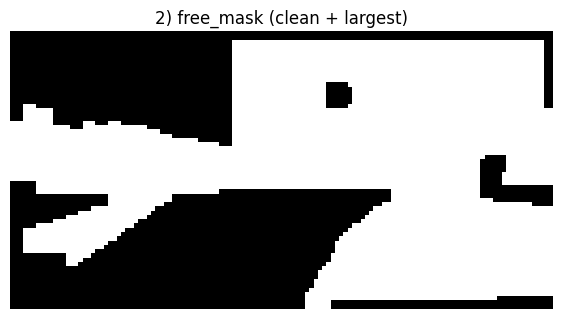

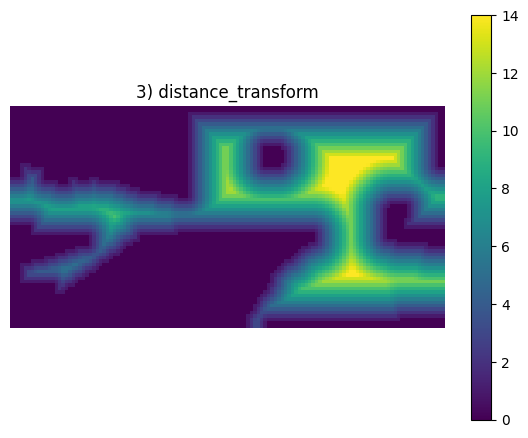

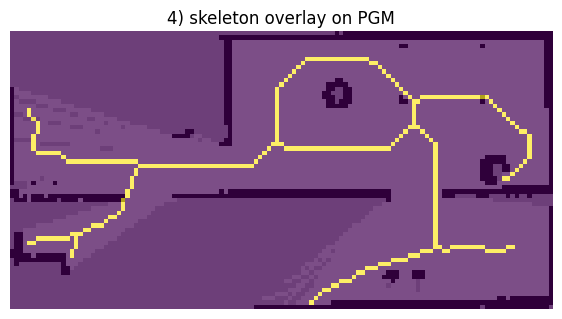

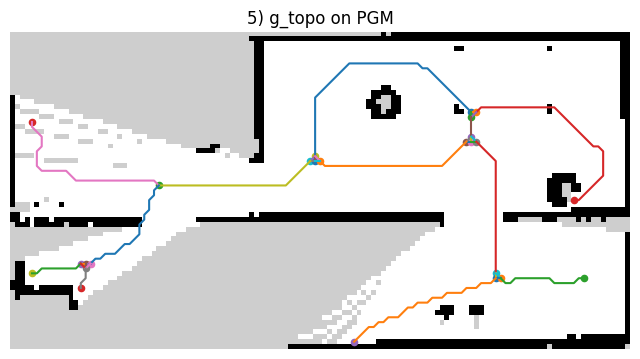

g_topo summary: {'nodes': 25, 'edges': 33, 'avg_degree': 2.64, 'max_degree': 4, 'min_degree': 1, 'graph_attrs': {'frame_id': 'map', 'resolution_m': 0.05, 'origin_xy_m': (0.0, 0.0)}, 'top_nodes_by_degree': [{'id': 'n4', 'deg': 4}, {'id': 'n8', 'deg': 4}, {'id': 'n17', 'deg': 4}, {'id': 'n0', 'deg': 3}, {'id': 'n1', 'deg': 3}, {'id': 'n2', 'deg': 3}, {'id': 'n5', 'deg': 3}, {'id': 'n6', 'deg': 3}, {'id': 'n7', 'deg': 3}, {'id': 'n9', 'deg': 3}]}


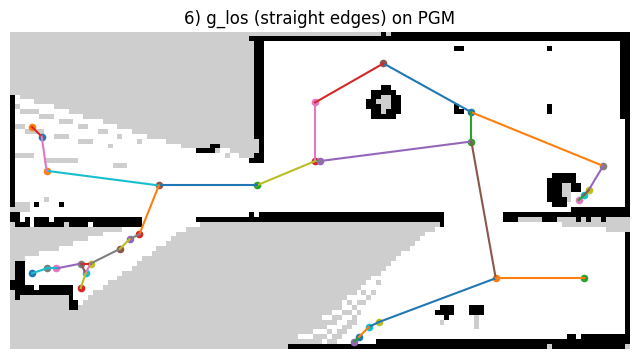

g_los summary: {'nodes': 31, 'edges': 32, 'avg_degree': 2.064516129032258, 'max_degree': 3, 'min_degree': 1, 'graph_attrs': {'frame_id': 'map', 'resolution_m': 0.05, 'origin_xy_m': (0.0, 0.0)}, 'top_nodes_by_degree': [{'id': 'm5_31', 'deg': 3}, {'id': 'm7_31', 'deg': 3}, {'id': 'm8_20', 'deg': 3}, {'id': 'n12', 'deg': 3}, {'id': 'n14', 'deg': 3}, {'id': 'm15_5', 'deg': 3}, {'id': 'm16_5', 'deg': 3}, {'id': 'm16_33', 'deg': 3}, {'id': 'n11', 'deg': 2}, {'id': 't0', 'deg': 2}]}


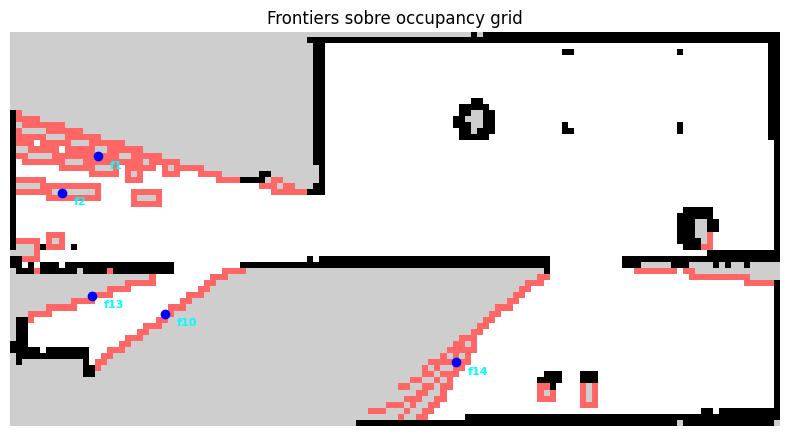

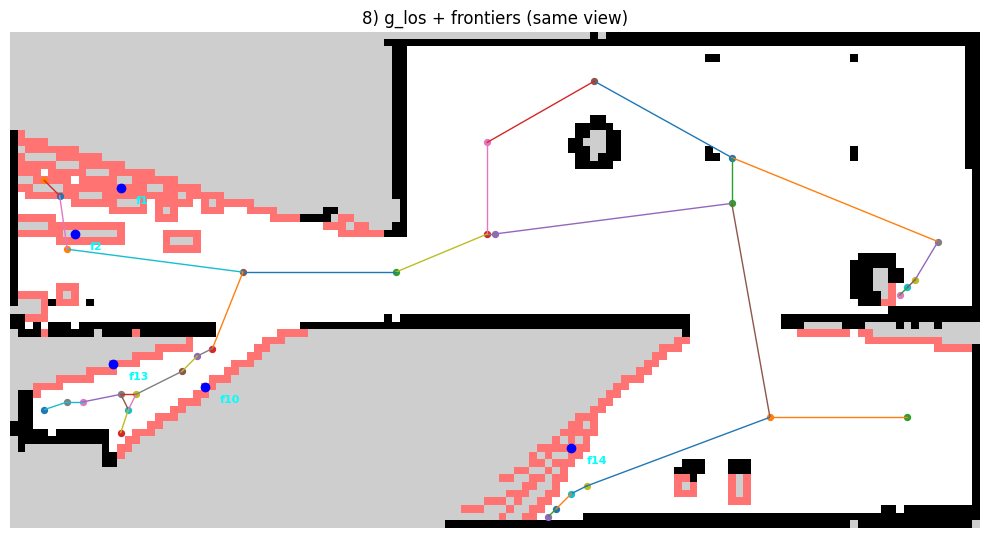

In [9]:
out = build_los_graph_and_frontiers_debug_from_pgm(
    "./maps/mi_mapa.pgm",#"willow-2010-02-18-0.10.pgm",
    viz=True,
    viz_graph_labels=False,
    viz_node_labels=False,
    viz_frontier_ids=True,
)


In [ ]:
import json
from typing import Any, Dict, Tuple, List
import networkx as nx


def llm_json_to_graph(payload: str) -> nx.Graph:
    """
    Convierte el JSON que genera graph_to_llm_json(...) a un nx.Graph.

    Soporta:
      - payload como str JSON
      - payload como dict (si ya lo has cargado)

    Restaura:
      - g.graph: frame_id, resolution_m, origin_xy_m
      - nodes: id, cell(tuple), xy_m(tuple), type, labels, ...
      - edges: from/to -> aristas con el resto de atributos
    """
    data = json.loads(payload) if isinstance(payload, str) else payload

    frame = data.get("frame", "map")
    resolution_m = float(data.get("resolution_m", 1.0))
    origin_xy_m = tuple(data.get("origin_xy_m", (0.0, 0.0)))

    g = nx.Graph(frame_id=frame, resolution_m=resolution_m, origin_xy_m=origin_xy_m)

    for nd in data.get("nodes", []):
        nid = nd["id"]
        attrs = dict(nd)
        attrs.pop("id", None)

        if "cell" in attrs and isinstance(attrs["cell"], list):
            r, c = attrs["_strcell"]
            attrs["cell"] = (int(r), int(c))

        if "xy_m" in attrs and isinstance(attrs["xy_m"], list):
            x, y = attrs["xy_m"]
            attrs["xy_m"] = (float(x), float(y))

        g.add_node(nid, **attrs)

    for ed in data.get("edges", []):
        u = ed["from"]
        v = ed["to"]
        attrs = dict(ed)
        attrs.pop("from", None)
        attrs.pop("to", None)

        # path_cells suele ser lista de [r,c] -> tuplas
        if "path_cells" in attrs and isinstance(attrs["path_cells"], list) and attrs["path_cells"]:
            if isinstance(attrs["path_cells"][0], list):
                attrs["path_cells"] = [(int(r), int(c)) for r, c in attrs["path_cells"]]

        # geometry.segment_xy_m suele ser [[x,y],[x,y]] -> tuplas
        geom = attrs.get("geometry")
        if isinstance(geom, dict):
            seg = geom.get("segment_xy_m")
            if isinstance(seg, list) and seg and isinstance(seg[0], list):
                geom["segment_xy_m"] = [(float(x), float(y)) for x, y in seg]
                attrs["geometry"] = geom

        g.add_edge(u, v, **attrs)

    return g


In [17]:
out = build_los_graph_and_frontiers_debug_from_pgm(
    "willow-2010-02-18-0.10.pgm",#"./maps/mi_mapa.pgm",#"willow-2010-02-18-0.10.pgm",
    viz=False,
    viz_graph_labels=False,
    viz_node_labels=False,
    viz_frontier_ids=True,
)

graph_json = out["graph_json"]
frontiers_json = out["frontiers_json"]
merged_json = out["merged_json"]

img = load_pgm_gray("willow-2010-02-18-0.10.pgm",)#"./maps/mi_mapa.pgm")

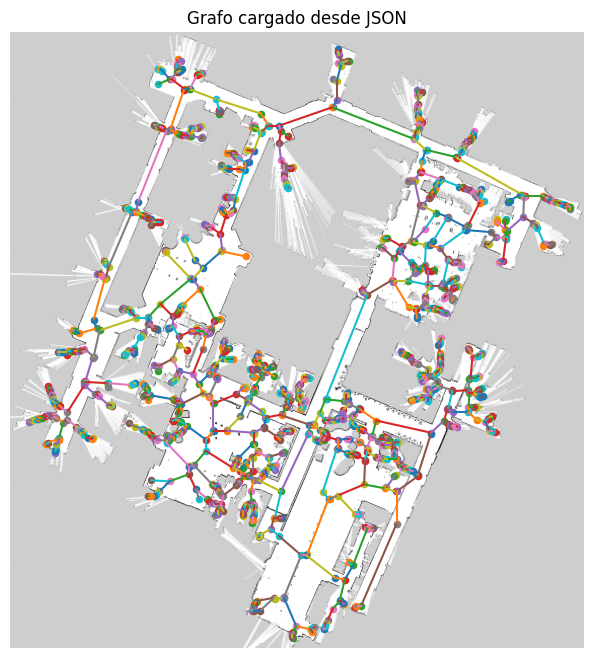

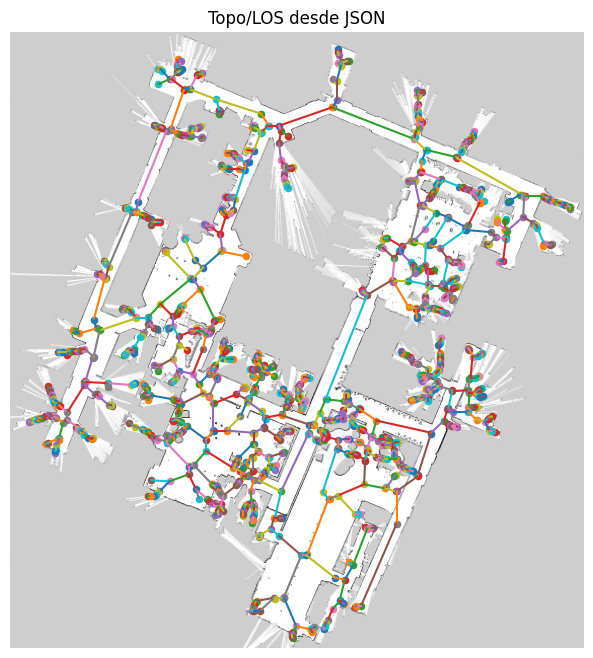

In [18]:
g = llm_json_to_graph(graph_json)
preview_graph_straight_edges_only(img, g, title="Grafo cargado desde JSON")
# o:
preview_graph_nodes_edges_on_grid(img, g, title="Topo/LOS desde JSON", draw_labels=False)


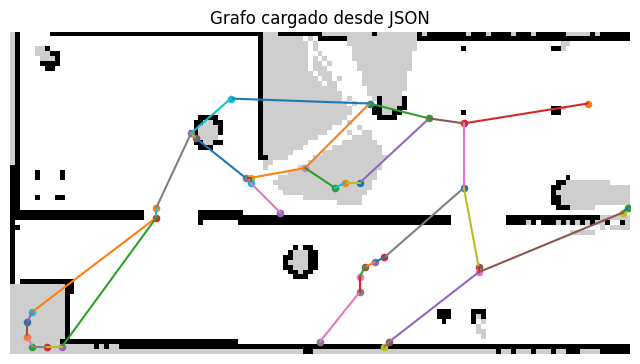

In [ ]:
import json
from pathlib import Path

p = Path("./maps/map_snapshot.json")

graph_json = json.loads(p.read_text(encoding="utf-8"))
img = load_pgm_gray("./maps/mapa_practica.pgm",)

g = llm_json_to_graph(graph_json)
preview_graph_straight_edges_only(img, g, title="Grafo cargado desde JSON")